In [2]:
#this program will generate the trust table based on frequency, intimacy and recency
#our mobile app is capable of generating these separately
#use this data for clustering in 3 classes [trusted, spam, unspecified or new number entry] to train your perceptron
import pandas as pd
import numpy as np
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

In [38]:
url1='generated/call_log.csv'
url2='generated/user_tendency.csv'
call_log = pd.read_csv(url1)
user_tendency=pd.read_csv(url2)

In [68]:
class CallDetails:
    in_dur=0
    out_dur=0
    in_f=0
    out_f=0
    date=0
    def __init__(self,no='9999999999',indur=0,outdur=0,inf=0,outf=0,dt=0):
        self.to_number=no
        self.in_dur=indur
        self.out_dur=outdur
        self.in_f=inf
        self.out_f=outf
        self.date=dt
        
class UserDetails:
    tot_durin=0
    tot_durout=0
    tendency=0
    tot_inf=0
    tot_outf=0
    def __init__(self,no='9999999999',din=0,dout=0,cin=0,cout=0,tend=0):
        self.tot_durin=din
        self.tot_durout=dout
        self.tendency=tend
        self.tot_inf=cin
        self.tot_outf=cout
        self.number=no

In [69]:
#number of unique numbers
no_rows=user_tendency.shape[0]
users=dict()
#storing per user details for future reference
for i in range(no_rows):
    callingno=  str(user_tendency.loc[i]['NUMBER']).split('.')[0]
    tot_in=user_tendency.loc[i]['TOT_IN_CALLS']
    tot_out=user_tendency.loc[i]['TOT_OUT_CALLS']
    indur=user_tendency.loc[i]['TOT_IN_DUR']
    outdur=user_tendency.loc[i]['TOT_OUT_DUR']
    tendy=user_tendency.loc[i]['TENDENCY']
    users[callingno]=UserDetails(callingno,indur,outdur,tot_in,tot_out,tendy)
len(users)

6553

In [60]:
#calldb will contain the stats of all calls made from one number to another 
calldb=dict()
query=("select * from call_log where RECORD_TYPE<>\"SMS\" ORDER BY CALL_DATE DESC;")
allcalls=pysql(query)
dformat='%d-%m-%Y  %H:%M'
no_rows=allcalls.shape[0]
for i in range(no_rows):
    callingno=str(allcalls.loc[i]['CALLING_NO'])
    calledno=str(allcalls.loc[i]['CALLED_NO'])
    if not (calledno =='5.43E+11' or callingno=='4.47E+11'):
        dur=allcalls.loc[i]['DURATION']
        #direction=allcalls.loc[i]['DIRECTION']
        ts = time.strptime(allcalls.loc[i]['CALL_DATE'],dformat )
        date= time.mktime(ts)
        if callingno not in calldb:
            calldb[callingno]=dict()
        if calledno not in calldb:
            calldb[calledno]=dict()
        outdur=0
        indur=0
        cin=0
        cout=0
        if calledno not in calldb[callingno]:
            calldb[callingno][calledno]=CallDetails(calledno,indur,outdur,cin,cout,date)
        if callingno not in calldb[calledno]:
            calldb[calledno][callingno]=CallDetails(callingno,indur,outdur,cin,cout,date)
        #note we dont update date since its being fed in date desc order
        #update sender creds
        calldb[callingno][calledno].out_dur+=dur
        calldb[callingno][calledno].out_f+=1
        #update receiver creds
        calldb[calledno][callingno].in_dur+=dur
        calldb[calledno][callingno].in_f+=1
    
len(calldb)


6551

In [73]:
import pickle as pkl
pkl.dump( calldb, open( "generated/calldb.pkl", "wb" ) )

PicklingError: Can't pickle <class '__main__.CallDetails'>: it's not the same object as __main__.CallDetails

In [75]:
import sys
#create new dataframe
columns = ['CALLING_NO','CALLED_NO','FREQUENCY','INTIMACY', 'RECENCY']
#tendency= total out duration/total duration
trustdb = pd.DataFrame(columns=columns)
i=0
for callingno in calldb.keys():
    mp=-1
    lp=sys.float_info.max
    for calledno in calldb[callingno].keys():
        if mp<calldb[callingno][calledno].date:
            mp=calldb[callingno][calledno].date
        if lp>calldb[callingno][calledno].date:
            lp=calldb[callingno][calledno].date   
    #period of consideration=(timestamp(most_recent_user)-timestamp(least_recent_user))
    period=mp-lp
    for calledno in calldb[callingno].keys():
        frequency,intimacy=0,0

        #frequency=#out_calls_to_that_person/#out_calls_to_everyone
        if users[callingno].tot_outf !=0:
            frequency=float(calldb[callingno][calledno].out_f)/users[callingno].tot_outf
            
        #intimacy=tendency*outgoingcalldur/totdur +(1-tendency)*incomingcalldur/totdur
        totdur=users[callingno].tot_durin+users[callingno].tot_durout
        if totdur !=0:
            c=float(calldb[callingno][calledno].out_dur)
            d=float(calldb[callingno][calledno].in_dur)
            tendency=users[callingno].tendency
            intimacy=tendency*c/totdur + (1-tendency)*d/totdur
        #recency=(timestamp(most_recent_user_person)-timestamp(least_recent_user))/total_period_of_consideration
        u_p=calldb[callingno][calledno].date
        recency=1
        if period!=0:
            recency=(u_p-lp)/period
        trustdb.loc[i]=[callingno,calledno,frequency,intimacy,recency]
        i+=1
trustdb

,CALLING_NO,CALLED_NO,FREQUENCY,INTIMACY,RECENCY
0,9719974132,9045999933,1.000000,0.725495,1
1,9045999933,9719974132,0.038591,0.013958,1
2,9045999933,9319603547,0.008389,0.002735,0.999802
3,9045999933,9319444005,0.016779,0.008095,0.998467
4,9045999933,9219723353,0.008389,0.001480,0.997231
5,9045999933,9896203763,0.013423,0.024961,0.996588
6,9045999933,9760587687,0.010067,0.006180,0.995302
7,9045999933,7500922332,0.031879,0.014766,0.993671
8,9045999933,9358152053,0.001678,0.004895,0.993374
9,9045999933,9758417306,0.104027,0.029146,0.993324


In [78]:
trustdb.to_csv('train/trustdb.csv')

In [3]:
url3='train/trustdb.csv'
trustdb = pd.read_csv(url3)

In [85]:
#for normalization in 0 to 1 use this, but this aint doing good normalization 
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
trustdb=trustdb.drop(['CALLING_NO','CALLED_NO'],axis=1)
mean=trustdb.mean()
sd=trustdb.std()
trustdb_norm=(trustdb-mean)/sd

In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters=4, random_state=0).fit(trustdb_norm.values)
centers = kmeans.cluster_centers_
Cluster=kmeans.predict(trustdb_norm)
'''
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(trustdb['FREQUENCY'],trustdb['INTIMACY'],c=Cluster,s=50)
for frequency,recency in centers:
    ax.scatter(frequency,recency,s=50,c='red',marker='+')
ax.set_xlabel('frequency')
ax.set_ylabel('intimacy')
plt.colorbar(scatter)
fig.show()
'''

"\nfig = plt.figure()\nax = fig.add_subplot(111)\nscatter = ax.scatter(trustdb['FREQUENCY'],trustdb['INTIMACY'],c=Cluster,s=50)\nfor frequency,recency in centers:\n    ax.scatter(frequency,recency,s=50,c='red',marker='+')\nax.set_xlabel('frequency')\nax.set_ylabel('intimacy')\nplt.colorbar(scatter)\nfig.show()\n"

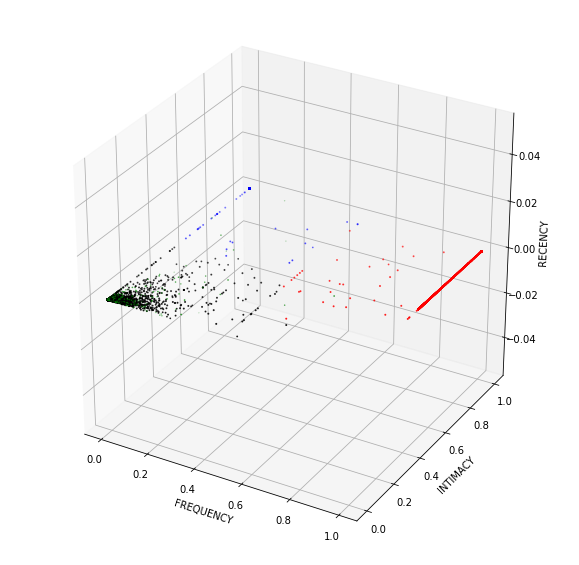

In [34]:
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))

#ax = Axes3D(fig, rect=[0, 0, 2, 2], elev=48, azim=134)
# Placement 0, 0 would be the bottom left, 1, 1 would be the top right.
#ax.text2D(0, 0, "TRUST CLUSTERS", transform=ax.transAxes)
ax = fig.gca(projection='3d')

labels = kmeans.labels_
colors=['red','green','blue','black']
col_map=dict(zip(set(labels),colors))
label_color = [col_map[l] for l in labels]
plt.scatter(trustdb['FREQUENCY'], trustdb['INTIMACY'], trustdb['RECENCY'], c=label_color)

ax.set_xlabel('FREQUENCY')
ax.set_ylabel('INTIMACY')
ax.set_zlabel('RECENCY')

plt.show()

In [108]:
print(mean)
print(sd)

FREQUENCY    0.254138
INTIMACY     0.438586
RECENCY      0.779383
dtype: float64
FREQUENCY    0.422264
INTIMACY     0.458369
RECENCY      0.314565
dtype: float64


In [114]:
trust_results=kmeans.predict(trustdb)
trustY = pd.DataFrame({'trust': trust_results})
trustdb1=trustdb.join(trustY)
trustdb1.to_csv('train/trustdb_gaussian.csv')

In [117]:
query0="SELECT * FROM trustdb1 WHERE trust=0;"#HIGH
trust0=pysql(query0)
query1="SELECT * FROM trustdb1 WHERE trust=1;"#SPAM
trust1=pysql(query1)
query2="SELECT * FROM trustdb1 WHERE trust=2;"#longDistanceRelationship low frequency just
trust2=pysql(query2)
query3="SELECT * FROM trustdb1 WHERE trust=3;"#recent, not intimate, below avg frequent
trust3=pysql(query3)


In [161]:
trustdb

,FREQUENCY,INTIMACY,RECENCY
0,1.000000,0.725495,1.000000
1,0.038591,0.013958,1.000000
2,0.008389,0.002735,0.999802
3,0.016779,0.008095,0.998467
4,0.008389,0.001480,0.997231
5,0.013423,0.024961,0.996588
6,0.010067,0.006180,0.995302
7,0.031879,0.014766,0.993671
8,0.001678,0.004895,0.993374
9,0.104027,0.029146,0.993324


In [22]:
red=0
blue=0
green=0
black=0
for i in labels:
    if i==0 :
        red+=1
    if i==1 :
        blue+=1
    if i==2 :
        green+=1
    if i==3:
        black+=1
print(str(red)+" "+str(blue)+" "+str(green)+" "+str(black))

6993 6413 0 0


In [11]:
set(labels)
print('red'+' blue'+' green'+' black')

array([1, 0, 0, ..., 2, 2, 2])